In [1]:
import xgboost as xgb
import lightgbm as lgb
import catboost as cat
import pandas as pd
import numpy as np

# plots
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# pandas / plt options
pd.options.display.max_columns = 999
plt.rcParams['figure.figsize'] = (14, 7)
font = {'family' : 'verdana',
        'weight' : 'bold',
        'size'   : 14}
plt.rc('font', **font)

# remove warnings
import warnings
warnings.simplefilter("ignore")

# garbage collector
import gc
gc.enable()

/Users/maqianli/anaconda3/lib/python3.6/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_9.4.1) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


In [2]:
train = pd.read_csv('extracted_fields_train.gz', dtype={'date': str, 'fullVisitorId': str, 'sessionId':str, 'visitId': np.int64})
test = pd.read_csv('extracted_fields_test.gz', dtype={'date': str, 'fullVisitorId': str, 'sessionId':str, 'visitId': np.int64})
train.shape, test.shape

((903653, 30), (804684, 30))

In [3]:
train_store_1 = pd.read_csv('Train_external_data.csv', low_memory=False, skiprows=6, dtype={"Client Id":'str'})
train_store_2 = pd.read_csv('Train_external_data_2.csv', low_memory=False, skiprows=6, dtype={"Client Id":'str'})
test_store_1 = pd.read_csv('Test_external_data.csv', low_memory=False, skiprows=6, dtype={"Client Id":'str'})
test_store_2 = pd.read_csv('Test_external_data_2.csv', low_memory=False, skiprows=6, dtype={"Client Id":'str'})

In [4]:
train_store_1.head()

,Client Id,Sessions,Avg. Session Duration,Bounce Rate,Revenue,Transactions,Goal Conversion Rate
0,1071704239.1484412669,2,00:03:10,0.00%,$234.16,2,400.00%
1,1073240909.1487180421,2,00:03:55,0.00%,$234.16,2,300.00%
2,1073518268.1481646866,4,00:09:36,0.00%,$234.16,2,250.00%
3,1073673252.1499477518,4,00:03:05,0.00%,$234.16,2,200.00%
4,1074548295.1493301594,2,00:05:30,0.00%,$234.16,2,300.00%


In [5]:
for df in [train_store_1, train_store_2, test_store_1, test_store_2]:
    df["visitId"] = df["Client Id"].apply(lambda x: x.split('.', 1)[1]).astype(np.int64)

In [6]:
train = train.merge(pd.concat([train_store_1, train_store_2], sort=False), how="left", on="visitId")
test = test.merge(pd.concat([test_store_1, test_store_2], sort=False), how="left", on="visitId")

# Drop Client Id
for df in [train, test]:
    df.drop("Client Id", 1, inplace=True)

In [7]:
# Cleaning Revenue
for df in [train, test]:
    df["Revenue"].fillna('$', inplace=True)
    df["Revenue"] = df["Revenue"].apply(lambda x: x.replace('$', '').replace(',', ''))
    df["Revenue"] = pd.to_numeric(df["Revenue"], errors="coerce")
    df["Revenue"].fillna(0.0, inplace=True)

In [8]:
for df in [train_store_1, train_store_2, test_store_1, test_store_2]:
    del df
gc.collect()

74

In [11]:
train.visitStartTime = pd.to_datetime(train.visitStartTime, unit='s')
test.visitStartTime = pd.to_datetime(test.visitStartTime, unit='s')
train["date"] = train.visitStartTime
test["date"] = test.visitStartTime

In [12]:
train.set_index("visitStartTime", inplace=True)
test.set_index("visitStartTime", inplace=True)
train.sort_index(inplace=True)
test.sort_index(inplace=True)

In [13]:
def clearRare(columnname, limit = 1000):
    # you may search for rare categories in train, train&test, or just test
    #vc = pd.concat([train[columnname], test[columnname]], sort=False).value_counts()
    vc = test[columnname].value_counts()
    
    common = vc > limit
    common = set(common.index[common].values)
    print("Set", sum(vc <= limit), columnname, "categories to 'other';", end=" ")
    
    train.loc[train[columnname].map(lambda x: x not in common), columnname] = 'other'
    test.loc[test[columnname].map(lambda x: x not in common), columnname] = 'other'
    print("now there are", train[columnname].nunique(), "categories in train")

In [14]:
train.fillna(0, inplace=True)
test.fillna(0, inplace=True)

In [15]:
clearRare("device.browser")
clearRare("device.operatingSystem")
clearRare("geoNetwork.country")
clearRare("geoNetwork.city")
clearRare("geoNetwork.metro")
clearRare("geoNetwork.networkDomain")
clearRare("geoNetwork.region")
clearRare("geoNetwork.subContinent")
clearRare("trafficSource.adContent")
clearRare("trafficSource.campaign")
clearRare("trafficSource.keyword")
clearRare("trafficSource.medium")
clearRare("trafficSource.referralPath")
clearRare("trafficSource.source")

Set 98 device.browser categories to 'other'; now there are 11 categories in train
Set 15 device.operatingSystem categories to 'other'; now there are 8 categories in train
Set 160 geoNetwork.country categories to 'other'; now there are 60 categories in train
Set 656 geoNetwork.city categories to 'other'; now there are 77 categories in train
Set 86 geoNetwork.metro categories to 'other'; now there are 24 categories in train
Set 25689 geoNetwork.networkDomain categories to 'other'; now there are 62 categories in train
Set 314 geoNetwork.region categories to 'other'; now there are 62 categories in train
Set 5 geoNetwork.subContinent categories to 'other'; now there are 19 categories in train
Set 46 trafficSource.adContent categories to 'other'; now there are 4 categories in train
Set 23 trafficSource.campaign categories to 'other'; now there are 5 categories in train
Set 2409 trafficSource.keyword categories to 'other'; now there are 8 categories in train
Set 1 trafficSource.medium categor

In [24]:
train.head(20)


,channelGrouping,date,fullVisitorId,sessionId,visitId,visitNumber,device.browser,device.deviceCategory,device.isMobile,device.operatingSystem,geoNetwork.city,geoNetwork.continent,geoNetwork.country,geoNetwork.metro,geoNetwork.networkDomain,geoNetwork.region,geoNetwork.subContinent,totals.bounces,totals.hits,totals.newVisits,totals.pageviews,totals.transactionRevenue,trafficSource.adContent,trafficSource.campaign,trafficSource.isTrueDirect,trafficSource.keyword,trafficSource.medium,trafficSource.referralPath,trafficSource.source,Sessions,Avg. Session Duration,Bounce Rate,Revenue,Transactions,Goal Conversion Rate,id_incoherence,visitId_dublicates,session_dublicates,weekday,time
visitStartTime,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-08-01 07:00:12,Direct,2016-08-01 07:00:12,0423043652415339154,0423043652415339154_1470034812,1470034812,3.0,Safari,mobile,1.0,iOS,not available in demo dataset,Americas,United States,not available in demo dataset,(not set),not available in demo dataset,Northern America,1.0,1.0,0.0,1.0,0.0,0,(not set),1.0,0,(none),0,(direct),0.0,0,0.0,0.0,0.0,0.0,False,1,1,0,25212
2016-08-01 07:04:26,Social,2016-08-01 07:04:26,8294721032567046680,8294721032567046680_1470035066,1470035066,1.0,Chrome,desktop,0.0,Windows,not available in demo dataset,Asia,Thailand,not available in demo dataset,unknown.unknown,not available in demo dataset,Southeast Asia,1.0,1.0,1.0,1.0,0.0,0,(not set),0.0,0,referral,/yt/about/,youtube.com,0.0,0,0.0,0.0,0.0,0.0,False,1,1,0,25466
2016-08-01 07:04:41,Organic Search,2016-08-01 07:04:41,7718623669497357235,7718623669497357235_1470035081,1470035081,1.0,other,tablet,1.0,Android,not available in demo dataset,Americas,United States,not available in demo dataset,(not set),not available in demo dataset,Northern America,0.0,5.0,1.0,5.0,0.0,0,(not set),0.0,(not provided),organic,0,google,0.0,0,0.0,0.0,0.0,0.0,False,1,1,0,25481
2016-08-01 07:06:01,Organic Search,2016-08-01 07:06:01,4798058133221713505,4798058133221713505_1470035161,1470035161,1.0,Chrome,desktop,0.0,Windows,not available in demo dataset,Americas,Canada,not available in demo dataset,bell.ca,not available in demo dataset,Northern America,0.0,9.0,1.0,7.0,0.0,0,(not set),0.0,(not provided),organic,0,google,0.0,0,0.0,0.0,0.0,0.0,False,1,1,0,25561
2016-08-01 07:06:10,Direct,2016-08-01 07:06:10,5076747981380011349,5076747981380011349_1470035170,1470035170,1.0,Chrome,desktop,0.0,Windows,other,Asia,Philippines,(not set),pldt.net,other,Southeast Asia,1.0,1.0,1.0,1.0,0.0,0,(not set),1.0,0,(none),0,(direct),0.0,0,0.0,0.0,0.0,0.0,False,1,1,0,25570
2016-08-01 07:08:12,Direct,2016-08-01 07:08:12,143953260196124648,143953260196124648_1470035292,1470035292,5.0,Safari,mobile,1.0,iOS,San Francisco,Americas,United States,San Francisco-Oakland-San Jose CA,(not set),California,Northern America,1.0,1.0,0.0,1.0,0.0,0,(not set),1.0,0,(none),0,(direct),0.0,0,0.0,0.0,0.0,0.0,False,1,1,0,25692
2016-08-01 07:10:29,Direct,2016-08-01 07:10:29,9234156111722725905,9234156111722725905_1470035429,1470035429,2.0,Safari,tablet,1.0,iOS,San Francisco,Americas,United States,San Francisco-Oakland-San Jose CA,(not set),California,Northern America,1.0,1.0,0.0,1.0,0.0,0,(not set),1.0,0,(none),0,(direct),0.0,0,0.0,0.0,0.0,0.0,False,1,1,0,25829
2016-08-01 07:10:57,Organic Search,2016-08-01 07:10:57,1757409464136963580,1757409464136963580_1470035457,1470035457,3.0,Chrome,mobile,1.0,Android,Santa Clara,Americas,United States,San Francisco-Oakland-San Jose CA,comcast.net,California,Northern America,0.0,7.0,0.0,5.0,0.0,0,(not set),0.0,(not provided),organic,0,google,0.0,0,0.0,0.0,0.0,0.0,False,1,1,0,25857
2016-08-01 07:11:41,Social,2016-08-01 07:11:41,3471645573420610711,3471645573420610711_1470035501,1470035501,1.0,Chrome,desktop,0.0,Windows,not available in demo dataset,Americas,United States,not available in demo dataset,verizon.net,not available in demo dataset,Northern America,1.0,1.0,1.0,1.0,0.0,0,(not set),0.0,0,referral,/yt/about/,youtube.com,0.0,0,0.0,0.0,0.0,0.0,False,1,

In [16]:
for df in [train, test]:
    df["Avg. Session Duration"][df["Avg. Session Duration"] == 0] = "00:00:00"
    df["Avg. Session Duration"] = df["Avg. Session Duration"].str.split(':').apply(lambda x: int(x[0]) * 60 + int(x[1]))
    df["Bounce Rate"] = df["Bounce Rate"].astype(str).apply(lambda x: x.replace('%', '')).astype(float)
    df["Goal Conversion Rate"] = df["Goal Conversion Rate"].astype(str).apply(lambda x: x.replace('%', '')).astype(float)

In [17]:
for df in [train, test]:
    # remember these features were equal, but not always? May be it means something...
    df["id_incoherence"] = pd.to_datetime(df.visitId, unit='s') != df.date
    # remember visitId dublicates?
    df["visitId_dublicates"] = df.visitId.map(df.visitId.value_counts())
    # remember session dublicates?
    df["session_dublicates"] = df.sessionId.map(df.sessionId.value_counts())

In [18]:
for df in [train, test]:
    df['weekday'] = df['date'].dt.dayofweek.astype(object)
    df['time'] = df['date'].dt.second + df['date'].dt.minute*60 + df['date'].dt.hour*3600
    #df['month'] = df['date'].dt.month   # it must not be included in features during learning!
    #df['day'] = df['date'].dt.date       # it must not be included in features during learning!

In [19]:
df = pd.concat([train, test])
df.sort_values(['fullVisitorId', 'date'], ascending=True, inplace=True)
df['prev_session'] = (df['date'] - df[['fullVisitorId', 'date']].groupby('fullVisitorId')['date'].shift(1)).astype(np.int64) // 1e9 // 60 // 60
df['next_session'] = (df['date'] - df[['fullVisitorId', 'date']].groupby('fullVisitorId')['date'].shift(-1)).astype(np.int64) // 1e9 // 60 // 60
df.sort_index(inplace=True)

train = df[:len(train)]
test = df[len(train):]

In [20]:
for df in [train, test]:
    df['source.country'] = df['trafficSource.source'] + '_' + df['geoNetwork.country']
    df['campaign.medium'] = df['trafficSource.campaign'] + '_' + df['trafficSource.medium']
    df['browser.category'] = df['device.browser'] + '_' + df['device.deviceCategory']
    df['browser.os'] = df['device.browser'] + '_' + df['device.operatingSystem']

In [21]:
for df in [train, test]:
    df['device_deviceCategory_channelGrouping'] = df['device.deviceCategory'] + "_" + df['channelGrouping']
    df['channelGrouping_browser'] = df['device.browser'] + "_" + df['channelGrouping']
    df['channelGrouping_OS'] = df['device.operatingSystem'] + "_" + df['channelGrouping']
    
    for i in ['geoNetwork.city', 'geoNetwork.continent', 'geoNetwork.country','geoNetwork.metro', 'geoNetwork.networkDomain', 'geoNetwork.region','geoNetwork.subContinent']:
        for j in ['device.browser','device.deviceCategory', 'device.operatingSystem', 'trafficSource.source']:
            df[i + "_" + j] = df[i] + "_" + df[j]
    
    df['content.source'] = df['trafficSource.adContent'].astype(str) + "_" + df['source.country']
    df['medium.source'] = df['trafficSource.medium'] + "_" + df['source.country']

In [22]:
for feature in ["totals.hits", "totals.pageviews"]:
    info = pd.concat([train, test], sort=False).groupby("fullVisitorId")[feature].mean()
    train["usermean_" + feature] = train.fullVisitorId.map(info)
    test["usermean_" + feature] = test.fullVisitorId.map(info)
    
for feature in ["visitNumber"]:
    info = pd.concat([train, test], sort=False).groupby("fullVisitorId")[feature].max()
    train["usermax_" + feature] = train.fullVisitorId.map(info)
    test["usermax_" + feature] = test.fullVisitorId.map(info)

In [23]:
excluded = ['date', 'fullVisitorId', 'sessionId', 'totals.transactionRevenue', 'visitId', 'visitStartTime', 
            'month', 'day', 'help']

cat_cols = [f for f in train.columns if (train[f].dtype == 'object' and f not in excluded)]
real_cols = [f for f in train.columns if (not f in cat_cols and f not in excluded)]

In [30]:
train[cat_cols].nunique()

channelGrouping                                       8
device.browser                                       11
device.deviceCategory                                 3
device.operatingSystem                                8
geoNetwork.city                                      77
geoNetwork.continent                                  6
geoNetwork.country                                   60
geoNetwork.metro                                     24
geoNetwork.networkDomain                             62
geoNetwork.region                                    62
geoNetwork.subContinent                              19
trafficSource.adContent                               4
trafficSource.campaign                                5
trafficSource.keyword                                 8
trafficSource.medium                                  7
trafficSource.referralPath                           17
trafficSource.source                                 22
weekday                                         

In [24]:
from sklearn.preprocessing import LabelEncoder
for col in cat_cols:
    lbl = LabelEncoder()
    lbl.fit(list(train[col].values.astype('str')) + list(test[col].values.astype('str')))
    train[col] = lbl.transform(list(train[col].values.astype('str')))
    test[col] = lbl.transform(list(test[col].values.astype('str')))

In [26]:
train.columns

Index(['channelGrouping', 'date', 'fullVisitorId', 'sessionId', 'visitId',
       'visitNumber', 'device.browser', 'device.deviceCategory',
       'device.isMobile', 'device.operatingSystem', 'geoNetwork.city',
       'geoNetwork.continent', 'geoNetwork.country', 'geoNetwork.metro',
       'geoNetwork.networkDomain', 'geoNetwork.region',
       'geoNetwork.subContinent', 'totals.bounces', 'totals.hits',
       'totals.newVisits', 'totals.pageviews', 'totals.transactionRevenue',
       'trafficSource.adContent', 'trafficSource.campaign',
       'trafficSource.isTrueDirect', 'trafficSource.keyword',
       'trafficSource.medium', 'trafficSource.referralPath',
       'trafficSource.source', 'Sessions', 'Avg. Session Duration',
       'Bounce Rate', 'Revenue', 'Transactions', 'Goal Conversion Rate',
       'id_incoherence', 'visitId_dublicates', 'session_dublicates', 'weekday',
       'time', 'prev_session', 'next_session', 'source.country',
       'campaign.medium', 'browser.category', 'b

In [31]:
z =train.corrwith(train['totals.transactionRevenue'])

In [36]:
z[60:]

geoNetwork.metro_device.operatingSystem            0.004898
geoNetwork.metro_trafficSource.source              0.004529
geoNetwork.networkDomain_device.browser           -0.021739
geoNetwork.networkDomain_device.deviceCategory    -0.021716
geoNetwork.networkDomain_device.operatingSystem   -0.021614
geoNetwork.networkDomain_trafficSource.source     -0.021710
geoNetwork.region_device.browser                  -0.009019
geoNetwork.region_device.deviceCategory           -0.008994
geoNetwork.region_device.operatingSystem          -0.008856
geoNetwork.region_trafficSource.source            -0.009237
geoNetwork.subContinent_device.browser            -0.014005
geoNetwork.subContinent_device.deviceCategory     -0.013908
geoNetwork.subContinent_device.operatingSystem    -0.013315
geoNetwork.subContinent_trafficSource.source      -0.014523
content.source                                    -0.009641
medium.source                                     -0.005803
usermean_totals.hits                    

In [37]:
excluded = ['date', 'fullVisitorId', 'sessionId', 'totals.transactionRevenue', 'visitId', 'visitStartTime', "month", "help"]

cat_cols = [f for f in train.columns if (train[f].dtype == 'int64' and f not in excluded)]
real_cols = [f for f in train.columns if (not f in cat_cols and f not in excluded)]

In [38]:
from sklearn.metrics import mean_squared_error
def score(data, y):
    validation_res = pd.DataFrame(
    {"fullVisitorId": data["fullVisitorId"].values,
     "transactionRevenue": data["totals.transactionRevenue"].values,
     "predictedRevenue": np.expm1(y)})

    validation_res = validation_res.groupby("fullVisitorId")["transactionRevenue", "predictedRevenue"].sum().reset_index()
    return np.sqrt(mean_squared_error(np.log1p(validation_res["transactionRevenue"].values), 
                                     np.log1p(validation_res["predictedRevenue"].values)))

In [39]:
from sklearn.model_selection import GroupKFold

class KFoldValidation():
    def __init__(self, data, n_splits=5):
        unique_vis = np.array(sorted(data['fullVisitorId'].astype(str).unique()))
        folds = GroupKFold(n_splits)
        ids = np.arange(data.shape[0])
        
        self.fold_ids = []
        for trn_vis, val_vis in folds.split(X=unique_vis, y=unique_vis, groups=unique_vis):
            self.fold_ids.append([
                    ids[data['fullVisitorId'].astype(str).isin(unique_vis[trn_vis])],
                    ids[data['fullVisitorId'].astype(str).isin(unique_vis[val_vis])]
                ])
            
    def validate(self, train, test, features, model, name="", prepare_stacking=False, 
                 fit_params={"early_stopping_rounds": 50, "verbose": 100, "eval_metric": "rmse"}):
        model.FI = pd.DataFrame(index=features)
        full_score = 0
        
        if prepare_stacking:
            test[name] = 0
            train[name] = np.NaN
        
        for fold_id, (trn, val) in enumerate(self.fold_ids):
            devel = train[features].iloc[trn]
            y_devel = np.log1p(train["totals.transactionRevenue"].iloc[trn])
            valid = train[features].iloc[val]
            y_valid = np.log1p(train["totals.transactionRevenue"].iloc[val])
                       
            print("Fold ", fold_id, ":")
            model.fit(devel, y_devel, eval_set=[(valid, y_valid)], **fit_params)
            
            if len(model.feature_importances_) == len(features):  # some bugs in catboost?
                model.FI['fold' + str(fold_id)] = model.feature_importances_ / model.feature_importances_.sum()

            predictions = model.predict(valid)
            predictions[predictions < 0] = 0
            print("Fold ", fold_id, " error: ", mean_squared_error(y_valid, predictions)**0.5)
            
            fold_score = score(train.iloc[val], predictions)
            full_score += fold_score / len(self.fold_ids)
            print("Fold ", fold_id, " score: ", fold_score)
            
            if prepare_stacking:
                train[name].iloc[val] = predictions
                test_predictions = model.predict(test[features])
                test_predictions[test_predictions < 0] = 0
                test[name] += test_predictions / len(self.fold_ids)
                
        print("Final score: ", full_score)
        return full_score

In [40]:
Kfolder = KFoldValidation(train)

In [41]:
lgbmodel = lgb.LGBMRegressor(n_estimators=1000, objective="regression", metric="rmse", num_leaves=31, min_child_samples=100,
                      learning_rate=0.03, bagging_fraction=0.7, feature_fraction=0.5, bagging_frequency=5, 
                      bagging_seed=2019, subsample=.9, colsample_bytree=.9, use_best_model=True)

In [42]:
Kfolder.validate(train, test, real_cols + cat_cols, lgbmodel, "lgbpred", prepare_stacking=True)

Fold  0 :
Training until validation scores don't improve for 50 rounds.
[100]	valid_0's rmse: 1.62263
[200]	valid_0's rmse: 1.59495
[300]	valid_0's rmse: 1.58553
[400]	valid_0's rmse: 1.58138
[500]	valid_0's rmse: 1.57917
[600]	valid_0's rmse: 1.57746
Early stopping, best iteration is:
[586]	valid_0's rmse: 1.57723
Fold  0  error:  1.576138404952594
Fold  0  score:  1.5585640854604133
Fold  1 :
Training until validation scores don't improve for 50 rounds.
[100]	valid_0's rmse: 1.59506
[200]	valid_0's rmse: 1.57098
[300]	valid_0's rmse: 1.56203
[400]	valid_0's rmse: 1.55792
[500]	valid_0's rmse: 1.55569
[600]	valid_0's rmse: 1.55442
[700]	valid_0's rmse: 1.55384
[800]	valid_0's rmse: 1.55301
[900]	valid_0's rmse: 1.55267
Early stopping, best iteration is:
[941]	valid_0's rmse: 1.55235
Fold  1  error:  1.5508636305577226
Fold  1  score:  1.5533994537505973
Fold  2 :
Training until validation scores don't improve for 50 rounds.
[100]	valid_0's rmse: 1.60793
[200]	valid_0's rmse: 1.57875
[

1.5502733150852204

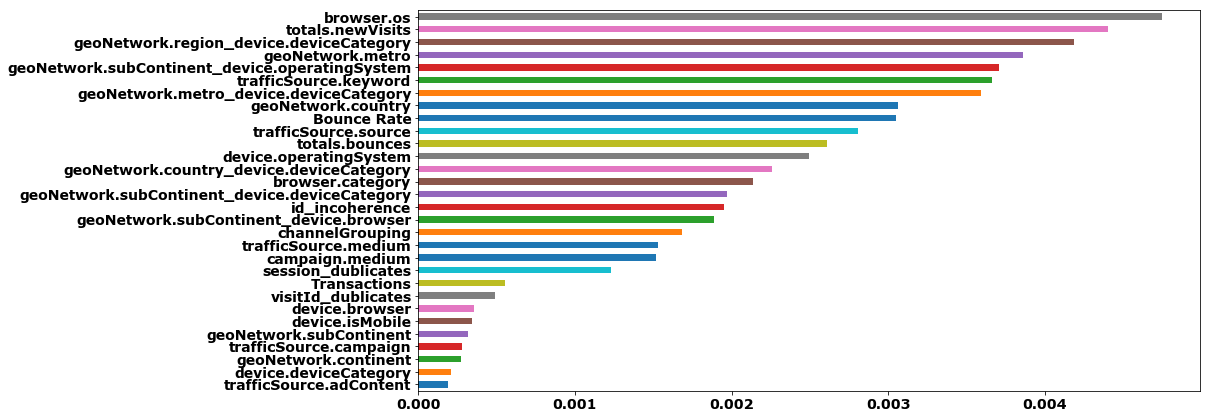

In [43]:
lgbmodel.FI.mean(axis=1).sort_values()[:30].plot(kind="barh")

In [44]:
def create_user_df(df):
    agg_data = df[real_cols + cat_cols + ['fullVisitorId']].groupby('fullVisitorId').mean()
    
    pred_list = df[['fullVisitorId', 'lgbpred']].groupby('fullVisitorId').apply(lambda visitor_df: list(visitor_df.lgbpred))\
        .apply(lambda x: {'pred_'+str(i): pred for i, pred in enumerate(x)})
    all_predictions = pd.DataFrame(list(pred_list.values), index=agg_data.index)
    feats = all_predictions.columns

    all_predictions['t_mean'] = all_predictions.mean(axis=1)
    all_predictions['t_median'] = all_predictions.median(axis=1)   # including t_mean as one of the elements? well, ok
    all_predictions['t_sum_log'] = all_predictions.sum(axis=1)
    all_predictions['t_sum_act'] = all_predictions.fillna(0).sum(axis=1)
    all_predictions['t_nb_sess'] = all_predictions.isnull().sum(axis=1)

    full_data = pd.concat([agg_data, all_predictions], axis=1).astype(float)
    full_data['fullVisitorId'] = full_data.index
    del agg_data, all_predictions
    gc.collect()
    return full_data

In [45]:
user_train = create_user_df(train)
user_test = create_user_df(test)

In [46]:
features = list(user_train.columns)[:-1]  # don't include "fullVisitorId"
user_train["totals.transactionRevenue"] = train[['fullVisitorId', 'totals.transactionRevenue']].groupby('fullVisitorId').sum()

In [47]:
for f in features:
    if f not in user_test.columns:
        user_test[f] = np.nan

In [48]:
Kfolder = KFoldValidation(user_train)

In [49]:
lgbmodel = lgb.LGBMRegressor(n_estimators=1000, objective="regression", metric="rmse", num_leaves=31, min_child_samples=100,
                      learning_rate=0.03, bagging_fraction=0.7, feature_fraction=0.5, bagging_frequency=5, 
                      bagging_seed=2019, subsample=.9, colsample_bytree=.9,
                            use_best_model=True)

In [50]:
Kfolder.validate(user_train, user_test, features, lgbmodel, name="lgbfinal", prepare_stacking=True)

Fold  0 :
Training until validation scores don't improve for 50 rounds.
[100]	valid_0's rmse: 1.50311
[200]	valid_0's rmse: 1.49619
Early stopping, best iteration is:
[182]	valid_0's rmse: 1.49616
Fold  0  error:  1.4959141417209278
Fold  0  score:  1.4959141417209278
Fold  1 :
Training until validation scores don't improve for 50 rounds.
[100]	valid_0's rmse: 1.50846
[200]	valid_0's rmse: 1.5071
Early stopping, best iteration is:
[150]	valid_0's rmse: 1.50555
Fold  1  error:  1.505399414162775
Fold  1  score:  1.505399414162775
Fold  2 :
Training until validation scores don't improve for 50 rounds.
[100]	valid_0's rmse: 1.50453
[200]	valid_0's rmse: 1.49879
Early stopping, best iteration is:
[201]	valid_0's rmse: 1.49879
Fold  2  error:  1.4986789324638616
Fold  2  score:  1.4986789324638616
Fold  3 :
Training until validation scores don't improve for 50 rounds.
[100]	valid_0's rmse: 1.48418
[200]	valid_0's rmse: 1.47877
[300]	valid_0's rmse: 1.47828
Early stopping, best iteration is:

1.4969157408478109

In [51]:
xgbmodel = xgb.XGBRegressor(max_depth=22, learning_rate=0.02, n_estimators=1000, 
                                         objective='reg:linear', gamma=1.45, seed=2019, silent=False,
                                        subsample=0.67, colsample_bytree=0.054, colsample_bylevel=0.50)
Kfolder.validate(user_train, user_test, features, xgbmodel, name="xgbfinal", prepare_stacking=True)

catmodel = cat.CatBoostRegressor(iterations=500, learning_rate=0.2, depth=5, random_seed=2019)
Kfolder.validate(user_train, user_test, features, catmodel, name="catfinal", prepare_stacking=True,
                fit_params={"use_best_model": True, "verbose": 100})


Fold  0 :
[11:17:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 3744 extra nodes, 102 pruned nodes, max_depth=22
[0]	validation_0-rmse:2.10214
Will train until validation_0-rmse hasn't improved in 50 rounds.
[11:17:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 5378 extra nodes, 40 pruned nodes, max_depth=22
[11:17:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 3098 extra nodes, 34 pruned nodes, max_depth=22
[11:17:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 204 extra nodes, 12 pruned nodes, max_depth=19
[11:17:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6602 extra nodes, 10 pruned nodes, max_depth=22
[11:17:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2776 extra nodes, 190 pruned nodes, max_depth=22
[11:17:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2114 extra nodes, 30 pruned nodes, max_depth=22
[11:17:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2012 extra nod

[11:19:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 3860 extra nodes, 1264 pruned nodes, max_depth=22
[11:19:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 706 extra nodes, 100 pruned nodes, max_depth=22
[11:19:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4596 extra nodes, 1608 pruned nodes, max_depth=22
[11:19:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6786 extra nodes, 4592 pruned nodes, max_depth=22
[11:19:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 3514 extra nodes, 1514 pruned nodes, max_depth=20
[11:19:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4116 extra nodes, 1842 pruned nodes, max_depth=22
[11:19:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 3394 extra nodes, 2404 pruned nodes, max_depth=22
[11:19:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 916 extra nodes, 408 pruned nodes, max_depth=22
[11:19:27] src/tree/updater_prune.cc:74: tree pruning end, 1

[11:20:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1060 extra nodes, 324 pruned nodes, max_depth=20
[11:21:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 7366 extra nodes, 10780 pruned nodes, max_depth=22
[11:21:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2146 extra nodes, 2456 pruned nodes, max_depth=22
[11:21:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4822 extra nodes, 4786 pruned nodes, max_depth=22
[11:21:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1550 extra nodes, 532 pruned nodes, max_depth=22
[11:21:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1218 extra nodes, 950 pruned nodes, max_depth=22
[11:21:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 994 extra nodes, 642 pruned nodes, max_depth=22
[11:21:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 146 extra nodes, 46 pruned nodes, max_depth=13
[11:21:10] src/tree/updater_prune.cc:74: tree pruning end, 1 ro

[11:22:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12278 extra nodes, 22092 pruned nodes, max_depth=22
[11:22:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1152 extra nodes, 940 pruned nodes, max_depth=13
[11:22:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 346 extra nodes, 332 pruned nodes, max_depth=20
[11:22:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1832 extra nodes, 1256 pruned nodes, max_depth=22
[11:22:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1448 extra nodes, 1010 pruned nodes, max_depth=22
[11:22:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1406 extra nodes, 1310 pruned nodes, max_depth=22
[11:22:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6450 extra nodes, 6338 pruned nodes, max_depth=22
[11:22:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 158 extra nodes, 42 pruned nodes, max_depth=22
[11:22:52] src/tree/updater_prune.cc:74: tree pruning end, 1

[11:24:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 884 extra nodes, 280 pruned nodes, max_depth=20
[11:24:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1232 extra nodes, 1046 pruned nodes, max_depth=22
[11:24:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 56 pruned nodes, max_depth=10
[11:24:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 820 extra nodes, 704 pruned nodes, max_depth=22
[11:24:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 256 extra nodes, 76 pruned nodes, max_depth=22
[11:24:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 754 extra nodes, 650 pruned nodes, max_depth=22
[11:24:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1364 extra nodes, 788 pruned nodes, max_depth=22
[11:24:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1618 extra nodes, 684 pruned nodes, max_depth=22
[11:24:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 314

[11:26:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1626 extra nodes, 1768 pruned nodes, max_depth=22
[11:26:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2220 extra nodes, 816 pruned nodes, max_depth=22
[11:26:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4222 extra nodes, 1618 pruned nodes, max_depth=22
[11:26:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2818 extra nodes, 1262 pruned nodes, max_depth=22
[11:26:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 414 extra nodes, 120 pruned nodes, max_depth=22
[11:26:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 66 extra nodes, 70 pruned nodes, max_depth=20
[11:26:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1484 extra nodes, 2866 pruned nodes, max_depth=22
[11:26:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2884 extra nodes, 2230 pruned nodes, max_depth=22
[11:26:13] src/tree/updater_prune.cc:74: tree pruning end, 1 ro

[11:27:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4416 extra nodes, 3002 pruned nodes, max_depth=22
[11:27:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2940 extra nodes, 6868 pruned nodes, max_depth=22
[11:27:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 236 extra nodes, 234 pruned nodes, max_depth=21
[11:27:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1804 extra nodes, 3252 pruned nodes, max_depth=22
[11:27:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1006 extra nodes, 1090 pruned nodes, max_depth=21
[11:27:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 32 pruned nodes, max_depth=11
[11:27:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6240 extra nodes, 6066 pruned nodes, max_depth=22
[11:27:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2728 extra nodes, 3282 pruned nodes, max_depth=22
[11:28:00] src/tree/updater_prune.cc:74: tree pruning end, 1 r

[11:29:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1952 extra nodes, 3966 pruned nodes, max_depth=22
[11:29:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 908 extra nodes, 336 pruned nodes, max_depth=22
[11:29:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 616 extra nodes, 558 pruned nodes, max_depth=22
[11:29:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 5590 extra nodes, 8400 pruned nodes, max_depth=22
[11:29:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2186 extra nodes, 916 pruned nodes, max_depth=22
[11:29:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 3884 extra nodes, 898 pruned nodes, max_depth=22
[11:29:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 232 extra nodes, 426 pruned nodes, max_depth=22
[11:29:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2960 extra nodes, 2026 pruned nodes, max_depth=22
[11:29:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roo

[11:31:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 460 extra nodes, 218 pruned nodes, max_depth=22
[11:31:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 142 extra nodes, 228 pruned nodes, max_depth=22
[11:31:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 204 pruned nodes, max_depth=22
[11:31:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 122 pruned nodes, max_depth=16
[11:31:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2556 extra nodes, 2192 pruned nodes, max_depth=22
[11:31:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 3852 extra nodes, 15524 pruned nodes, max_depth=22
[11:31:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8286 extra nodes, 8586 pruned nodes, max_depth=22
[11:31:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 144 extra nodes, 616 pruned nodes, max_depth=15
[11:31:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots

[11:36:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 7528 extra nodes, 1930 pruned nodes, max_depth=22
[11:36:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2484 extra nodes, 618 pruned nodes, max_depth=21
[11:36:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 586 extra nodes, 92 pruned nodes, max_depth=21
[11:36:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1908 extra nodes, 472 pruned nodes, max_depth=22
[11:36:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2858 extra nodes, 936 pruned nodes, max_depth=22
[11:36:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1420 extra nodes, 426 pruned nodes, max_depth=22
[11:36:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 398 extra nodes, 100 pruned nodes, max_depth=16
[11:36:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 794 extra nodes, 146 pruned nodes, max_depth=18
[11:36:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots,

[11:38:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1750 extra nodes, 1238 pruned nodes, max_depth=22
[11:38:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 292 extra nodes, 68 pruned nodes, max_depth=21
[11:38:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2766 extra nodes, 2240 pruned nodes, max_depth=22
[11:38:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1906 extra nodes, 894 pruned nodes, max_depth=22
[11:38:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 3032 extra nodes, 2804 pruned nodes, max_depth=22
[11:38:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 110 pruned nodes, max_depth=22
[11:38:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4250 extra nodes, 2852 pruned nodes, max_depth=22
[11:38:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 68 extra nodes, 14 pruned nodes, max_depth=9
[11:38:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots,

[11:39:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 9204 extra nodes, 17436 pruned nodes, max_depth=22
[11:39:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2008 extra nodes, 998 pruned nodes, max_depth=22
[11:39:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1832 extra nodes, 1866 pruned nodes, max_depth=22
[11:39:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2300 extra nodes, 1242 pruned nodes, max_depth=22
[11:39:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 3364 extra nodes, 5700 pruned nodes, max_depth=22
[11:39:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 938 extra nodes, 436 pruned nodes, max_depth=22
[11:39:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1004 extra nodes, 1578 pruned nodes, max_depth=22
[11:40:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 3690 extra nodes, 2292 pruned nodes, max_depth=22
[11:40:02] src/tree/updater_prune.cc:74: tree pruning end,

[11:41:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8322 extra nodes, 15510 pruned nodes, max_depth=22
[11:41:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4670 extra nodes, 3212 pruned nodes, max_depth=22
[11:41:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4926 extra nodes, 5588 pruned nodes, max_depth=22
[11:41:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 5608 extra nodes, 7928 pruned nodes, max_depth=22
[11:41:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2662 extra nodes, 4652 pruned nodes, max_depth=22
[11:41:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 3244 extra nodes, 6376 pruned nodes, max_depth=22
[11:41:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 226 extra nodes, 62 pruned nodes, max_depth=22
[11:41:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 244 extra nodes, 206 pruned nodes, max_depth=22
[11:41:51] src/tree/updater_prune.cc:74: tree pruning end, 1

[11:43:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 26 pruned nodes, max_depth=6
[11:43:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 82 pruned nodes, max_depth=9
[11:43:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 3722 extra nodes, 810 pruned nodes, max_depth=22
[11:43:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 842 extra nodes, 730 pruned nodes, max_depth=22
[11:43:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1272 extra nodes, 548 pruned nodes, max_depth=22
[11:43:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 888 extra nodes, 1670 pruned nodes, max_depth=22
[11:43:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 3594 extra nodes, 8128 pruned nodes, max_depth=22
[11:43:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1140 extra nodes, 1128 pruned nodes, max_depth=22
[11:43:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 463

[11:45:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 164 extra nodes, 236 pruned nodes, max_depth=21
[11:45:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2684 extra nodes, 3852 pruned nodes, max_depth=22
[11:45:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 446 extra nodes, 484 pruned nodes, max_depth=18
[11:45:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 800 extra nodes, 380 pruned nodes, max_depth=22
[11:45:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 7056 extra nodes, 13710 pruned nodes, max_depth=22
[11:45:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1036 extra nodes, 2032 pruned nodes, max_depth=22
[11:45:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 754 extra nodes, 362 pruned nodes, max_depth=22
[11:45:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1632 extra nodes, 924 pruned nodes, max_depth=22
[11:45:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roo

[11:47:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 798 extra nodes, 676 pruned nodes, max_depth=22
[11:47:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2466 extra nodes, 3176 pruned nodes, max_depth=22
[11:47:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 94 extra nodes, 68 pruned nodes, max_depth=20
[11:47:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 196 pruned nodes, max_depth=15
[11:47:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6232 extra nodes, 14108 pruned nodes, max_depth=22
[11:47:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 3430 extra nodes, 3846 pruned nodes, max_depth=22
[11:47:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 190 extra nodes, 624 pruned nodes, max_depth=22
[11:47:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 3680 extra nodes, 4986 pruned nodes, max_depth=22
[11:47:25] src/tree/updater_prune.cc:74: tree pruning end, 1 root

[11:49:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 154 pruned nodes, max_depth=16
[11:49:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 7660 extra nodes, 14574 pruned nodes, max_depth=22
[11:49:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1688 extra nodes, 2450 pruned nodes, max_depth=22
[11:49:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 74 pruned nodes, max_depth=12
[11:49:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 214 extra nodes, 216 pruned nodes, max_depth=20
[11:49:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 166 extra nodes, 376 pruned nodes, max_depth=22
[11:49:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2330 extra nodes, 9634 pruned nodes, max_depth=22
[11:49:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2474 extra nodes, 2284 pruned nodes, max_depth=22
[11:49:18] src/tree/updater_prune.cc:74: tree pruning end, 1 root

[11:54:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 134 extra nodes, 0 pruned nodes, max_depth=19
[11:54:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6454 extra nodes, 342 pruned nodes, max_depth=22
[11:54:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 204 extra nodes, 8 pruned nodes, max_depth=15
[11:54:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=6
[11:55:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4770 extra nodes, 208 pruned nodes, max_depth=22
[11:55:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 636 extra nodes, 32 pruned nodes, max_depth=22
[11:55:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1004 extra nodes, 20 pruned nodes, max_depth=17
[11:55:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6078 extra nodes, 640 pruned nodes, max_depth=22
[11:55:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8290 extra

[11:56:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 160 extra nodes, 36 pruned nodes, max_depth=12
[11:56:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6200 extra nodes, 2418 pruned nodes, max_depth=22
[11:56:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 5986 extra nodes, 4116 pruned nodes, max_depth=22
[11:56:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8476 extra nodes, 3484 pruned nodes, max_depth=22
[11:56:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1416 extra nodes, 738 pruned nodes, max_depth=22
[11:56:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 5522 extra nodes, 6034 pruned nodes, max_depth=22
[11:56:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 748 extra nodes, 202 pruned nodes, max_depth=21
[11:56:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4284 extra nodes, 2122 pruned nodes, max_depth=22
[11:56:52] src/tree/updater_prune.cc:74: tree pruning end, 1 r

[11:58:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 7056 extra nodes, 4160 pruned nodes, max_depth=22
[11:58:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1890 extra nodes, 690 pruned nodes, max_depth=22
[11:58:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2970 extra nodes, 3764 pruned nodes, max_depth=22
[11:58:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 210 extra nodes, 16 pruned nodes, max_depth=17
[11:58:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2642 extra nodes, 2362 pruned nodes, max_depth=22
[11:58:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 944 extra nodes, 234 pruned nodes, max_depth=21
[11:58:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4860 extra nodes, 3332 pruned nodes, max_depth=22
[11:58:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1440 extra nodes, 824 pruned nodes, max_depth=22
[11:58:39] src/tree/updater_prune.cc:74: tree pruning end, 1 ro

[12:00:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1264 extra nodes, 1108 pruned nodes, max_depth=22
[12:00:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2310 extra nodes, 1140 pruned nodes, max_depth=22
[12:00:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4068 extra nodes, 2368 pruned nodes, max_depth=22
[12:00:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1776 extra nodes, 1546 pruned nodes, max_depth=22
[12:00:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1762 extra nodes, 1776 pruned nodes, max_depth=22
[12:00:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1310 extra nodes, 1482 pruned nodes, max_depth=22
[12:00:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8268 extra nodes, 14360 pruned nodes, max_depth=22
[12:00:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 5780 extra nodes, 7752 pruned nodes, max_depth=22
[12:00:22] src/tree/updater_prune.cc:74: tree pruning e

[12:12:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 3848 extra nodes, 3658 pruned nodes, max_depth=22
[12:12:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1384 extra nodes, 1330 pruned nodes, max_depth=22
[12:12:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 350 extra nodes, 146 pruned nodes, max_depth=22
[12:12:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1106 extra nodes, 978 pruned nodes, max_depth=22
[12:13:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 950 extra nodes, 1622 pruned nodes, max_depth=22
[12:13:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 940 extra nodes, 296 pruned nodes, max_depth=22
[12:13:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 7266 extra nodes, 11866 pruned nodes, max_depth=22
[12:13:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6052 extra nodes, 11014 pruned nodes, max_depth=22
[12:13:18] src/tree/updater_prune.cc:74: tree pruning end, 1

[12:42:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6898 extra nodes, 12346 pruned nodes, max_depth=22
[12:42:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 942 extra nodes, 732 pruned nodes, max_depth=22
[12:42:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1254 extra nodes, 1860 pruned nodes, max_depth=22
[12:42:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1148 extra nodes, 188 pruned nodes, max_depth=22
[12:42:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2434 extra nodes, 1820 pruned nodes, max_depth=22
[12:42:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1572 extra nodes, 980 pruned nodes, max_depth=22
[12:42:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2938 extra nodes, 3566 pruned nodes, max_depth=22
[12:42:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1964 extra nodes, 2964 pruned nodes, max_depth=22
[12:42:37] src/tree/updater_prune.cc:74: tree pruning end, 

[20:38:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1702 extra nodes, 1004 pruned nodes, max_depth=22
[20:38:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1012 extra nodes, 688 pruned nodes, max_depth=22
[20:38:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 342 extra nodes, 398 pruned nodes, max_depth=22
[20:38:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 3646 extra nodes, 3606 pruned nodes, max_depth=22
[20:38:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4814 extra nodes, 8482 pruned nodes, max_depth=22
[20:38:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2818 extra nodes, 2308 pruned nodes, max_depth=22
[20:38:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8524 extra nodes, 23000 pruned nodes, max_depth=22
[20:38:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 664 extra nodes, 1216 pruned nodes, max_depth=22
[20:38:38] src/tree/updater_prune.cc:74: tree pruning end, 

[500]	validation_0-rmse:1.52666
[20:40:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 102 pruned nodes, max_depth=6
[20:40:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1436 extra nodes, 1244 pruned nodes, max_depth=22
[20:40:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 5518 extra nodes, 1554 pruned nodes, max_depth=22
[20:40:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1680 extra nodes, 1986 pruned nodes, max_depth=22
[20:40:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 732 extra nodes, 584 pruned nodes, max_depth=22
[20:40:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 102 pruned nodes, max_depth=11
[20:40:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 926 extra nodes, 814 pruned nodes, max_depth=22
[20:40:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4428 extra nodes, 1498 pruned nodes, max_depth=22
[20:41:03] src/tree/updater_prune.c

[20:43:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 146 extra nodes, 334 pruned nodes, max_depth=22
[20:43:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2100 extra nodes, 4412 pruned nodes, max_depth=22
[20:43:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 886 extra nodes, 698 pruned nodes, max_depth=22
[20:43:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 432 extra nodes, 664 pruned nodes, max_depth=21
[20:43:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2626 extra nodes, 1174 pruned nodes, max_depth=22
[20:43:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 844 extra nodes, 472 pruned nodes, max_depth=22
[20:43:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4710 extra nodes, 14222 pruned nodes, max_depth=22
[20:43:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6098 extra nodes, 15064 pruned nodes, max_depth=22
[20:43:18] src/tree/updater_prune.cc:74: tree pruning end, 1 r

[20:45:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 3196 extra nodes, 3572 pruned nodes, max_depth=22
[20:45:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 330 extra nodes, 764 pruned nodes, max_depth=22
[20:45:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1360 extra nodes, 1492 pruned nodes, max_depth=22
[20:45:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2584 extra nodes, 4054 pruned nodes, max_depth=21
[20:45:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2460 extra nodes, 4740 pruned nodes, max_depth=22
[20:45:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 266 extra nodes, 750 pruned nodes, max_depth=22
[20:45:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 820 extra nodes, 458 pruned nodes, max_depth=22
[20:45:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 182 extra nodes, 334 pruned nodes, max_depth=19
[20:45:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roo

[20:57:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4608 extra nodes, 408 pruned nodes, max_depth=22
[20:57:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 580 extra nodes, 86 pruned nodes, max_depth=22
[20:57:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6696 extra nodes, 910 pruned nodes, max_depth=22
[20:57:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2632 extra nodes, 534 pruned nodes, max_depth=22
[20:57:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 3412 extra nodes, 832 pruned nodes, max_depth=22
[20:57:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 7002 extra nodes, 1318 pruned nodes, max_depth=22
[20:57:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 142 extra nodes, 14 pruned nodes, max_depth=16
[20:57:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 616 extra nodes, 86 pruned nodes, max_depth=22
[20:57:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2

[20:58:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 9516 extra nodes, 3652 pruned nodes, max_depth=22
[20:58:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1280 extra nodes, 418 pruned nodes, max_depth=22
[100]	validation_0-rmse:1.62647
[20:58:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 3868 extra nodes, 1186 pruned nodes, max_depth=22
[20:59:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1394 extra nodes, 878 pruned nodes, max_depth=22
[20:59:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 610 extra nodes, 50 pruned nodes, max_depth=18
[20:59:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 9594 extra nodes, 7012 pruned nodes, max_depth=22
[20:59:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4636 extra nodes, 5112 pruned nodes, max_depth=22
[20:59:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6802 extra nodes, 7914 pruned nodes, max_depth=22
[20:59:08] src/tree/updater_p

[21:00:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1506 extra nodes, 526 pruned nodes, max_depth=20
[21:00:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 5266 extra nodes, 11486 pruned nodes, max_depth=22
[21:00:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 294 extra nodes, 66 pruned nodes, max_depth=19
[21:00:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 3086 extra nodes, 2186 pruned nodes, max_depth=22
[21:00:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1152 extra nodes, 308 pruned nodes, max_depth=22
[21:00:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1466 extra nodes, 1710 pruned nodes, max_depth=22
[21:00:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1496 extra nodes, 792 pruned nodes, max_depth=22
[21:00:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1830 extra nodes, 734 pruned nodes, max_depth=22
[21:00:51] src/tree/updater_prune.cc:74: tree pruning end, 1 r

[21:02:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1234 extra nodes, 572 pruned nodes, max_depth=22
[21:02:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 3690 extra nodes, 2290 pruned nodes, max_depth=22
[21:02:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6240 extra nodes, 11794 pruned nodes, max_depth=22
[21:02:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4886 extra nodes, 3540 pruned nodes, max_depth=22
[21:02:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2356 extra nodes, 1658 pruned nodes, max_depth=22
[21:02:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8404 extra nodes, 19174 pruned nodes, max_depth=22
[21:02:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 168 extra nodes, 164 pruned nodes, max_depth=22
[21:02:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4032 extra nodes, 7852 pruned nodes, max_depth=22
[21:02:37] src/tree/updater_prune.cc:74: tree pruning end

[21:04:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1270 extra nodes, 462 pruned nodes, max_depth=22
[21:04:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 5144 extra nodes, 6704 pruned nodes, max_depth=22
[21:04:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2132 extra nodes, 1664 pruned nodes, max_depth=22
[21:04:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1078 extra nodes, 2662 pruned nodes, max_depth=22
[21:04:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4606 extra nodes, 6292 pruned nodes, max_depth=22
[21:04:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 60 pruned nodes, max_depth=10
[21:04:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 68 extra nodes, 74 pruned nodes, max_depth=12
[21:04:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1552 extra nodes, 2012 pruned nodes, max_depth=22
[21:04:26] src/tree/updater_prune.cc:74: tree pruning end, 1 root

[21:05:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 380 extra nodes, 244 pruned nodes, max_depth=12
[21:06:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 996 extra nodes, 672 pruned nodes, max_depth=22
[21:06:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2020 extra nodes, 2342 pruned nodes, max_depth=22
[21:06:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1270 extra nodes, 708 pruned nodes, max_depth=22
[21:06:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 966 extra nodes, 660 pruned nodes, max_depth=22
[21:06:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2982 extra nodes, 9452 pruned nodes, max_depth=22
[21:06:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 272 extra nodes, 152 pruned nodes, max_depth=21
[21:06:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 308 extra nodes, 446 pruned nodes, max_depth=21
[21:06:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots,

[21:07:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 3172 extra nodes, 2218 pruned nodes, max_depth=22
[21:07:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1178 extra nodes, 1424 pruned nodes, max_depth=22
[21:07:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2548 extra nodes, 3468 pruned nodes, max_depth=22
[21:07:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1396 extra nodes, 516 pruned nodes, max_depth=22
[21:07:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 226 extra nodes, 290 pruned nodes, max_depth=22
[21:07:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 264 extra nodes, 164 pruned nodes, max_depth=16
[21:07:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 584 extra nodes, 540 pruned nodes, max_depth=22
[21:07:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1106 extra nodes, 3000 pruned nodes, max_depth=22
[21:07:50] src/tree/updater_prune.cc:74: tree pruning end, 1 ro

[21:09:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 268 extra nodes, 2176 pruned nodes, max_depth=21
[21:09:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2018 extra nodes, 4800 pruned nodes, max_depth=22
[21:09:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 284 extra nodes, 342 pruned nodes, max_depth=18
[21:09:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 148 extra nodes, 172 pruned nodes, max_depth=22
[21:09:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4472 extra nodes, 2826 pruned nodes, max_depth=22
[21:09:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 352 extra nodes, 104 pruned nodes, max_depth=22
[21:09:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 344 pruned nodes, max_depth=17
[21:09:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 3016 extra nodes, 5158 pruned nodes, max_depth=22
[21:09:35] src/tree/updater_prune.cc:74: tree pruning end, 1 root

[21:17:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4196 extra nodes, 132 pruned nodes, max_depth=22
[21:17:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4870 extra nodes, 24 pruned nodes, max_depth=22
[21:17:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1666 extra nodes, 18 pruned nodes, max_depth=22
[21:18:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 3316 extra nodes, 198 pruned nodes, max_depth=22
[21:18:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 5828 extra nodes, 68 pruned nodes, max_depth=22
[21:18:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 600 extra nodes, 8 pruned nodes, max_depth=22
[21:18:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 5656 extra nodes, 102 pruned nodes, max_depth=22
[21:18:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2142 extra nodes, 60 pruned nodes, max_depth=22
[21:18:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 193

[21:20:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1744 extra nodes, 548 pruned nodes, max_depth=22
[21:20:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 7006 extra nodes, 2502 pruned nodes, max_depth=22
[21:20:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2308 extra nodes, 764 pruned nodes, max_depth=22
[21:20:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 7374 extra nodes, 2760 pruned nodes, max_depth=22
[21:20:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6476 extra nodes, 1932 pruned nodes, max_depth=22
[21:20:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 212 extra nodes, 70 pruned nodes, max_depth=14
[21:20:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 882 extra nodes, 226 pruned nodes, max_depth=22
[21:20:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 480 extra nodes, 84 pruned nodes, max_depth=15
[21:20:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots

[21:22:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 174 extra nodes, 174 pruned nodes, max_depth=15
[21:22:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 470 extra nodes, 250 pruned nodes, max_depth=19
[21:22:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 176 extra nodes, 12 pruned nodes, max_depth=19
[21:22:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1042 extra nodes, 586 pruned nodes, max_depth=22
[21:22:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6626 extra nodes, 3680 pruned nodes, max_depth=22
[21:22:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2086 extra nodes, 918 pruned nodes, max_depth=22
[21:22:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2254 extra nodes, 1614 pruned nodes, max_depth=22
[21:22:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 556 extra nodes, 120 pruned nodes, max_depth=22
[21:22:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots,

[21:23:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6154 extra nodes, 5258 pruned nodes, max_depth=22
[21:23:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1022 extra nodes, 448 pruned nodes, max_depth=17
[21:23:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 404 extra nodes, 398 pruned nodes, max_depth=22
[21:23:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2442 extra nodes, 3250 pruned nodes, max_depth=22
[21:23:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4102 extra nodes, 7138 pruned nodes, max_depth=22
[21:23:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4124 extra nodes, 6494 pruned nodes, max_depth=22
[21:23:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 138 extra nodes, 40 pruned nodes, max_depth=22
[21:24:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1132 extra nodes, 616 pruned nodes, max_depth=22
[21:24:01] src/tree/updater_prune.cc:74: tree pruning end, 1 ro

[21:25:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 3392 extra nodes, 2728 pruned nodes, max_depth=22
[21:25:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 156 extra nodes, 52 pruned nodes, max_depth=10
[21:25:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 690 extra nodes, 560 pruned nodes, max_depth=22
[21:25:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2400 extra nodes, 2562 pruned nodes, max_depth=22
[21:25:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 824 extra nodes, 392 pruned nodes, max_depth=15
[21:25:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 934 extra nodes, 284 pruned nodes, max_depth=22
[21:25:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2868 extra nodes, 2034 pruned nodes, max_depth=22
[21:25:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1862 extra nodes, 1108 pruned nodes, max_depth=22
[21:25:45] src/tree/updater_prune.cc:74: tree pruning end, 1 root

[21:27:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 134 extra nodes, 152 pruned nodes, max_depth=22
[21:27:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1084 extra nodes, 1182 pruned nodes, max_depth=22
[21:27:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 3656 extra nodes, 5540 pruned nodes, max_depth=22
[21:27:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 5974 extra nodes, 35538 pruned nodes, max_depth=22
[21:27:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4978 extra nodes, 10668 pruned nodes, max_depth=21
[21:27:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2894 extra nodes, 5318 pruned nodes, max_depth=22
[21:27:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4372 extra nodes, 3154 pruned nodes, max_depth=22
[21:27:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 3588 extra nodes, 3230 pruned nodes, max_depth=22
[21:27:30] src/tree/updater_prune.cc:74: tree pruning en

[21:29:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 11182 extra nodes, 16988 pruned nodes, max_depth=22
[21:29:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 5234 extra nodes, 3922 pruned nodes, max_depth=22
[21:29:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 3066 extra nodes, 3148 pruned nodes, max_depth=22
[21:29:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4440 extra nodes, 11940 pruned nodes, max_depth=22
[21:29:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 82 extra nodes, 50 pruned nodes, max_depth=22
[21:29:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 630 extra nodes, 310 pruned nodes, max_depth=22
[21:29:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 540 extra nodes, 364 pruned nodes, max_depth=15
[21:29:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1092 extra nodes, 696 pruned nodes, max_depth=22
[21:29:12] src/tree/updater_prune.cc:74: tree pruning end, 1 r

[21:30:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2746 extra nodes, 2574 pruned nodes, max_depth=22
[21:30:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 3676 extra nodes, 5184 pruned nodes, max_depth=22
[21:30:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1504 extra nodes, 4040 pruned nodes, max_depth=22
[21:30:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 236 extra nodes, 348 pruned nodes, max_depth=22
[500]	validation_0-rmse:1.52995
[21:30:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1686 extra nodes, 2954 pruned nodes, max_depth=22
[21:30:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 320 extra nodes, 334 pruned nodes, max_depth=21
[21:31:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2772 extra nodes, 2432 pruned nodes, max_depth=22
[21:31:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1444 extra nodes, 1026 pruned nodes, max_depth=22
[21:31:04] src/tree/updater_

[21:32:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1332 extra nodes, 1578 pruned nodes, max_depth=22
[21:32:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 3258 extra nodes, 2906 pruned nodes, max_depth=22
[21:32:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 3558 extra nodes, 10518 pruned nodes, max_depth=22
[21:32:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1106 extra nodes, 1010 pruned nodes, max_depth=22
[21:32:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 584 extra nodes, 234 pruned nodes, max_depth=22
[21:32:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 200 extra nodes, 596 pruned nodes, max_depth=21
[21:32:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 880 extra nodes, 1034 pruned nodes, max_depth=22
[21:32:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 474 extra nodes, 784 pruned nodes, max_depth=22
[21:32:56] src/tree/updater_prune.cc:74: tree pruning end, 1 r

Fold  3  score:  1.4776291556521504
Fold  4 :
0:	learn: 1.9242997	test: 1.9319274	best: 1.9319274 (0)	total: 313ms	remaining: 2m 36s
100:	learn: 1.4623568	test: 1.5071927	best: 1.5060561 (85)	total: 31.1s	remaining: 2m 2s
200:	learn: 1.4356142	test: 1.5098197	best: 1.5060561 (85)	total: 1m 3s	remaining: 1m 34s
300:	learn: 1.4128346	test: 1.5121868	best: 1.5060561 (85)	total: 1m 36s	remaining: 1m 3s
400:	learn: 1.3905164	test: 1.5171132	best: 1.5060561 (85)	total: 2m 11s	remaining: 32.3s
499:	learn: 1.3731811	test: 1.5187312	best: 1.5060561 (85)	total: 2m 44s	remaining: 0us

bestTest = 1.506056059
bestIteration = 85

Shrink model to first 86 iterations.
Fold  4  error:  1.5060160237276254
Fold  4  score:  1.5060160237276254
Final score:  1.4987189699356156


1.4987189699356156

In [54]:
user_train[['lgbfinal','xgbfinal','catfinal']] = pd.read_csv('z.csv')

In [55]:
user_test[['lgbfinal','xgbfinal','catfinal']] = to_csv('z_test.csv')

In [59]:
user_train['PredictedLogRevenue'].to_csv('y.csv')

KeyError: 'PredictedLogRevenue'

In [61]:
user_train.columns

Index(['visitNumber', 'device.isMobile', 'totals.bounces', 'totals.hits',
       'totals.newVisits', 'totals.pageviews', 'trafficSource.isTrueDirect',
       'Sessions', 'Bounce Rate', 'Revenue',
       ...
       't_mean', 't_median', 't_sum_log', 't_sum_act', 't_nb_sess',
       'fullVisitorId', 'totals.transactionRevenue', 'lgbfinal', 'xgbfinal',
       'catfinal'],
      dtype='object', length=365)

In [93]:
user_train['PredictedLogRevenue'] = 0.4 * user_train["lgbfinal"] + \
                                    0.2 * user_train["xgbfinal"] + \
                                    0.4 * user_train["catfinal"]
#user_train['PredictedLogRevenue'] = user_train["lgbfinal"]
score(user_train, user_train.PredictedLogRevenue)

1.495436296842344

In [94]:
user_test['PredictedLogRevenue'] = 0.4 * user_test["lgbfinal"] +  0.4 * user_test["catfinal"] + 0.2 * user_test["xgbfinal"]
#user_test['PredictedLogRevenue'] = user_test["lgbfinal"]
user_test[['PredictedLogRevenue']].to_csv('prediction.csv', index=True)